# main文件


# Myspider文件


运行结果：

import scrapy
from ..items import PictureItem
from protego import Protego
from selenium import webdriver
from scrapy.selector import Selector
from selenium.webdriver.chrome.options import Options
import time

chorme_options = Options()
chorme_options.add_argument("--headless")
chorme_options.add_argument("--disable-gpu")

class MySpider(scrapy.Spider):
    #用于区别Spider
    name = "MySpider"
    #允许访问的域
    allowed_domains = []
    #爬取的地址
    start_urls = ["https://gracg.com/search/index_new?key=%E7%8C%AB%E5%92%AA"]

    # 实例化一个浏览器对象
    def __init__(self):
        self.browser = webdriver.Chrome(chrome_options=chorme_options)
        super().__init__()

    def start_requests(self):
        #读取前4页的图片数据信息
        for urlnum in range(1,5):
            url = "https://gracg.com/search/index_new?key=%E7%8C%AB%E5%92%AA&ot=0&type=1&page="+str(urlnum)

            headers={
                        'Connection': 'keep-alive',
                         'Cache-Control': 'max-age=0',
                         'DNT': '1',
                        'Upgrade-Insecure-Requests': '1',
                        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36'

                    }
            response = scrapy.Request(url,headers=headers, callback=self.parse_index)
            yield response

    # 整个爬虫结束后关闭浏览器
    def close(self, spider):
        self.browser.quit()

    #爬取简介页面方法
    def parse_index(self, response):
        #实例一个容器保存爬取的信息
        filename = "picture.html"
        with open(filename, 'wb') as f:
            f.write(response.body)
        f.close()
        for box in response.xpath('//div[@class="container"]/div[@class="row"]/div/div[1]/div[1]/a[2]'):
            url = 'http://gracg.com' + box.xpath('.//@href').extract()[0]
            print("url",url)
            # 获取详情页面的url并用parse_detail方法解析
            response=scrapy.Request(url,callback=self.parse_detail)
            time.sleep(0.1)
            yield response

    # 爬取详情页面方法
    def parse_detail(self, response):
        with open("item.html", 'wb') as f:
            f.write(response.body)
        f.close()
        div_res = response.xpath('//div[@class=" col-12 col-lg-9   pl-0  pr-0 "]')
        name = div_res.xpath('.//div[@class="font-weight-bold font-24  "]/text()').extract()
        print("name",name)
        count = div_res.xpath('.//div[@class="d-flex flex-row font-12   pb-2"]')
        seen = count.xpath('./div[1]/span/text()').extract()
        thumb_up = count.xpath('./div[2]/span/text()').extract()
        comment = count.xpath('./div[3]/span/text()').extract()
        tags = div_res.xpath('.//a[@class=" border-50 p-2 font-12 rounded d-block mr-1 mb-1 "]/text()')[1:].extract()
        # 存入Item中并发送给pipeline
        item = PictureItem()
        item["name"]=name
        item["seen"] = seen
        item["thumb_up"] = thumb_up
        item["comment"] = comment
        item["tags"] = tags
        yield item


 # 运行结果

# 可视化处理

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


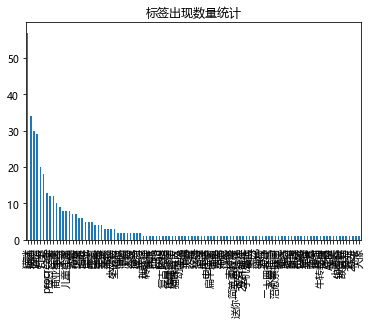

In [2]:
import pandas
import matplotlib.pyplot as plt
from pylab import mpl

#mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']    # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False           # 解决保存图像是负号'-'显示为方块的问题

# 读取pandas文件
df = pandas.read_json(path_or_buf="data.json", orient='records',lines=True, encoding='utf-8',convert_dates=False)
print(type(df['tags'][0]))
print(type(df))

# 利用字典来统计tag出现的数量
count_dict = dict()
for index,row in df.iterrows():
    for item in row[-1]:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1
# print(count_dict)
ser = pandas.Series(count_dict)
# print(ser)

# 排序
ser.sort_values(ascending = False,inplace = True)
# 画图
plt.figure()
ser.plot(kind='bar')
plt.title('标签出现数量统计')
plt.show()

